Use GPyTorch
Use Periodic kernel

In [1]:
import os
import sys
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

 # Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

import experiment_util
from plot_helpers import *
plotter = PlotUtilGPyTorch()

Read the first time series

In [2]:
USE_CUDA = False
#if torch.cuda.device_count() > 0:
#    torch.cuda.set_device(0)
#    print("USE GPU")

In [3]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [4]:
df = pd.read_csv("./data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [5]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

Zoomed in on the first N observations

In [6]:
N=X.shape[0]
N_part=11300

In [7]:
X_part=X[:N_part]
Y_part=Y[:N_part]

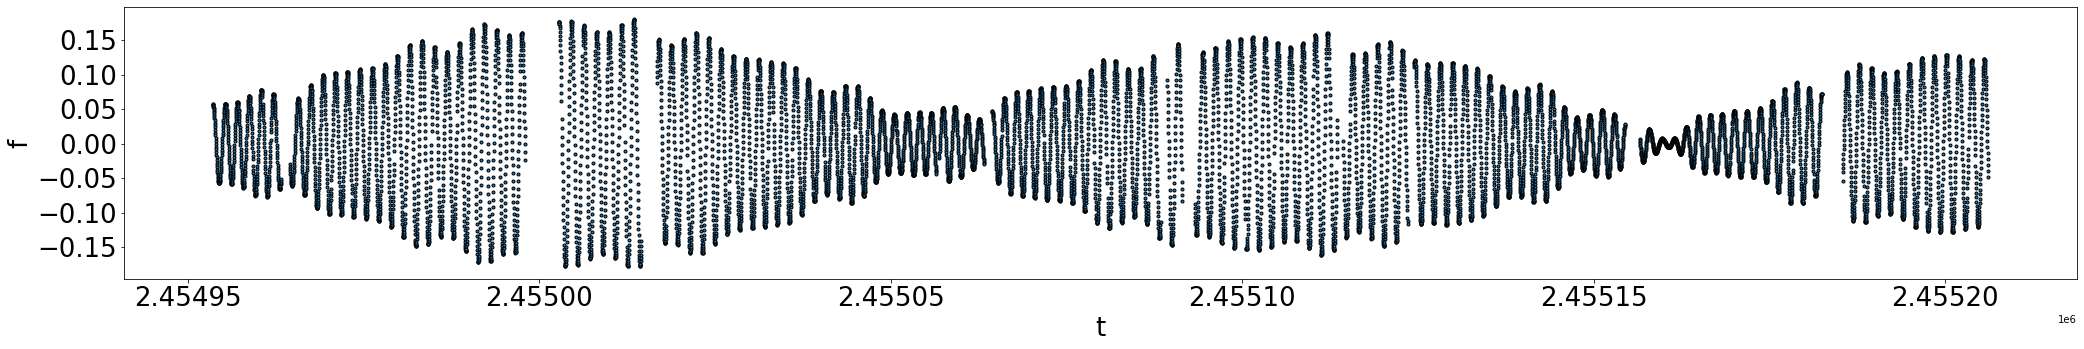

In [8]:
plotter.plot_data(X_part, Y_part)

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [9]:
X_part=torch.tensor(X[:N_part])
Y_part=torch.tensor(Y[:N_part])

In [10]:
# Ignore: Don't normalize here, as the data is already mean centered and we have included the RMSE
# numbers already in the paper.
_, _, Y_part = experiment_util.normalize_mean(Y_part)

In [11]:
# Predict evenly spaced points on our time-axis
X_part_smooth = torch.tensor(np.linspace(X_part.min(), X_part.max(), N_part))

In [12]:
# In 5 runs of the notebook, add these one by one
#cov_matrix5 = cov.Cov(X_part,
#   sho1 = term.SHOKernel(sig=-0.056267, P0=1/0.5673, Q=8000.36505),
#   sho2 = term.SHOKernel(sig=-0.0000000004314, P0=1/0.5575, Q=200000.36505),
#   sho3 = term.SHOKernel(sig=-0.0000000000000000004314, P0=1/0.5685, Q=200000.36505),
#   sho4 = term.SHOKernel(sig=-0.0000000000000000004314, P0=1/0.6594, Q=200000.36505),
#   sho5 = term.SHOKernel(sig=-0.0000000000000000004314, P0=1/0.4348, Q=200000.36505))

In [13]:
from gpytorch.priors import NormalPrior

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        # Periodic kernel 1
        sho1 = gpytorch.kernels.PeriodicKernel()
        sho1.period_length = 1/0.5673
        sho1.lengthscale = 0.001
        # Periodic kernel 2
        sho2 = gpytorch.kernels.PeriodicKernel()
        sho2.period_length = 1/0.5575
        sho2.lengthscale = 0.001
        # Periodic kernel 3
        sho3 = gpytorch.kernels.PeriodicKernel()
        sho3.period_length = 1/0.5685
        sho3.lengthscale = 0.001
        # Periodic kernel 4
        sho4 = gpytorch.kernels.PeriodicKernel()
        sho4.period_length = 1/0.6594
        sho4.lengthscale = 0.001
        # Periodic kernel 5
        sho5 = gpytorch.kernels.PeriodicKernel()
        sho5.period_length = 1/0.4348
        sho5.lengthscale = 0.001
        # RBF kernel for the uncorrelated noise
        self.noise_kernel = gpytorch.kernels.RBFKernel()

        self.covar_module = gpytorch.kernels.AdditiveKernel(
            gpytorch.kernels.ScaleKernel(sho1),
            gpytorch.kernels.ScaleKernel(sho2),
            gpytorch.kernels.ScaleKernel(sho3),
            gpytorch.kernels.ScaleKernel(sho4),
            gpytorch.kernels.ScaleKernel(sho5),            
            gpytorch.kernels.ScaleKernel(self.noise_kernel),
        )
       
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_part, Y_part, likelihood)

# As we are using float64 data, we need to convert our model to double
_ = model.double()
_ = likelihood.double()

Move data and models to the GPU

In [14]:
if USE_CUDA:
    X_part = X_part.cuda()
    X_part_smooth = X_part_smooth.cuda()
    Y_part = Y_part.cuda()
    model = model.cuda()
    likelihood = likelihood.cuda()

In [15]:
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer on a subset of the hyperparameters
all_params = set(model.parameters())
final_params = all_params
# final_params = list(all_params - {model.covar_module.base_kernel.raw_period_length})
optimizer = torch.optim.Adam(final_params, lr=0.15)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_part)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_part)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   period: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        0,
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.936   period: 0.000   noise: 0.693
Iter 2/50 - Loss: 1.110   period: 0.000   noise: 0.621
Iter 3/50 - Loss: 0.976   period: 0.000   noise: 0.555
Iter 4/50 - Loss: 0.850   period: 0.000   noise: 0.494
Iter 5/50 - Loss: 0.764   period: 0.000   noise: 0.438
Iter 6/50 - Loss: 0.688   period: 0.000   noise: 0.387
Iter 7/50 - Loss: 0.612   period: 0.000   noise: 0.341
Iter 8/50 - Loss: 0.528   period: 0.000   noise: 0.299
Iter 9/50 - Loss: 0.464   period: 0.000   noise: 0.262
Iter 10/50 - Loss: 0.397   period: 0.000   noise: 0.229
Iter 11/50 - Loss: 0.334   period: 0.000   noise: 0.199
Iter 12/50 - Loss: 0.272   period: 0.000   noise: 0.173
Iter 13/50 - Loss: 0.201   period: 0.000   noise: 0.150
Iter 14/50 - Loss: 0.130   period: 0.000   noise: 0.130
Iter 15/50 - Loss: 0.067   period: 0.000   noise: 0.112
Iter 16/50 - Loss: -0.014   period: 0.000   noise: 0.097
Iter 17/50 - Loss: -0.085   period: 0.000   noise: 0.084
Iter 18/50 - Loss: -0.161   period: 0.000   noise: 0.07

In [16]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    Y_part_pred = likelihood(model(X_part))
    
# Test points are regularly spaced along train_x
# Make predictions by feeding model through likelihood
# with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     mu_part_smooth = likelihood(model(X_part_smooth))

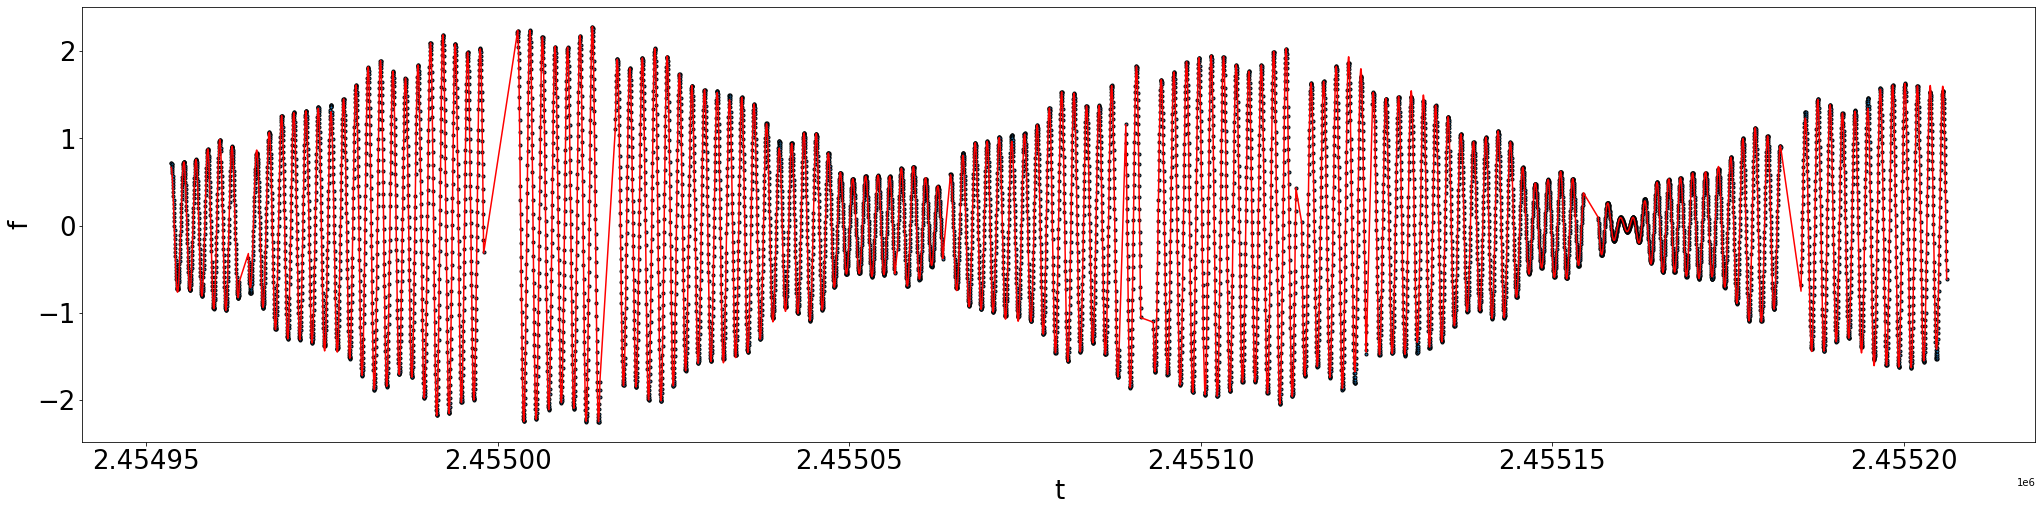

In [17]:
with torch.no_grad():
    plotter.plot_series(X_part.cpu().numpy(), Y_part.cpu().numpy(), X_part.cpu().numpy(), Y_part_pred.mean.cpu().numpy())

### RMSE

In [18]:
experiment_util.calculate_error(Y_part, Y_part_pred.mean.cpu())

TimeSeriesSimilarity(correlation=0.9997004893885734, rmse=0.0244895535897575)